In [1]:
import os
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from multiprocessing import Pool

from utils import (
    logging,
    PLOTS_DIR,
    TRAINING_DATA_FILE,
    DUMMY_SEQ_NAMES_FILE,
    MUTATION_SCORES_FILE,
)
from utils.miscellaneous import calculate_pred_AA
from utils.visualization import plot_umap


In [2]:
logging.info("Load data..")

seq_mut: pd.DataFrame = pd.read_feather(TRAINING_DATA_FILE)
mutation_scores: pd.DataFrame = pd.read_feather(MUTATION_SCORES_FILE)

with open(DUMMY_SEQ_NAMES_FILE) as f:
    dummy_seq_names = json.load(f)


In [6]:
true_AA = seq_mut.loc[~seq_mut["Accession"].isin(dummy_seq_names)]
true_AA = true_AA[["Accession", "Pos", "AA"]]
true_AA = true_AA.sort_values(["Accession", "Pos"])
true_AA = true_AA.reset_index(drop=True)

In [3]:
aa_table = seq_mut[["AA", "AA_idx"]].drop_duplicates()
aa_table = aa_table.set_index("AA_idx").sort_index()
aa_table = aa_table["AA"]

In [4]:
pred_scores = mutation_scores.loc[~mutation_scores["Accession"].isin(
    dummy_seq_names)]


In [5]:
with Pool(os.cpu_count()) as p:
    pred_AA = p.starmap(
        func=calculate_pred_AA,
        iterable=((*i, aa_table)
                  for i in pred_scores.groupby("Accession", sort=False))
    )
    pred_AA = pd.concat(pred_AA)
    pred_AA = pred_AA.sort_values(["Accession", "Pos"])
    pred_AA = pred_AA.reset_index(drop=True)


In [15]:
sum(true_AA["AA"] == pred_AA["AA"]) / len(true_AA)

0.9980754839971319

In [34]:
aa_freq = (true_AA["Pos"].astype(str) + true_AA["AA"]).value_counts()
n_seq = pred_scores["Accession"].nunique()


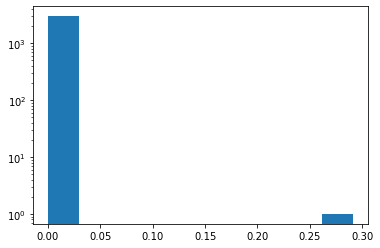

In [52]:
missed_AA = true_AA[true_AA["AA"] != pred_AA["AA"]]
missed_AA = (missed_AA["Pos"].astype(str) + missed_AA["AA"]).unique()
plt.hist([aa_freq[aa] / n_seq for aa in missed_AA])
plt.yscale("log")
plt.savefig("plots/missed_AA_freq.pdf")

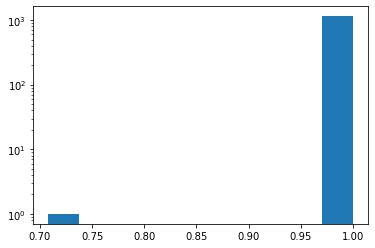

In [53]:
correct_AA = true_AA[true_AA["AA"] == pred_AA["AA"]]
correct_AA = (correct_AA["Pos"].astype(str) + correct_AA["AA"]).unique()
plt.hist([aa_freq[aa] / n_seq for aa in correct_AA])
plt.yscale("log")
plt.savefig("plots/correct_AA_freq.pdf")